In [1]:
DATA_URL = './ArtData/'

import os

In [2]:
for cls in os.listdir(DATA_URL):
  print(cls, ':', len(os.listdir(DATA_URL + '/' + cls)))

m-c-escher : 418
salvador-dali : 1098
rene-magritte : 366
albrecht-durer : 831
andre-masson : 110


In [3]:
from torchvision.datasets import ImageFolder

In [4]:
DATASET = ImageFolder(DATA_URL)

In [5]:
len(DATASET)

2823

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline


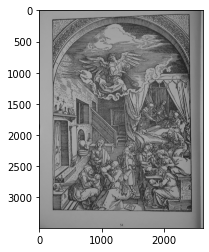

In [8]:
IMG, LABEL = DATASET[0]
plt.imshow(IMG)

In [9]:
IMG, LABEL = DATASET[555]

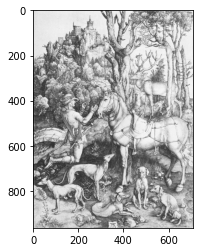

In [10]:
plt.imshow(IMG)

In [11]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader

In [12]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(DATA_URL, transform=tt.Compose([
    tt.Resize(IMAGE_SIZE),
    tt.CenterCrop(IMAGE_SIZE),
    tt.ToTensor(),
    tt.Normalize(*STATS)]))

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

In [14]:
from torchvision.utils import make_grid


In [15]:

def denorm(_imgTensors):
    return _imgTensors * STATS[1][0] + STATS[0][0]

In [16]:
def show_images(_images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(_images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [17]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

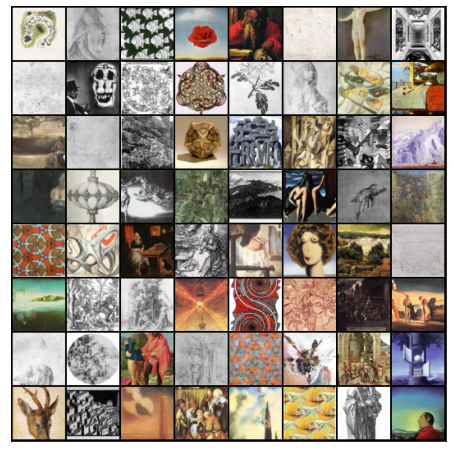

In [18]:
show_batch(train_dl)


In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
import torch


In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = DeviceDataLoader(train_dl, device)


In [23]:
import torch.nn as nn


In [24]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [25]:
discriminator = to_device(discriminator, device)


In [26]:
LATENT_SIZE = 128



generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


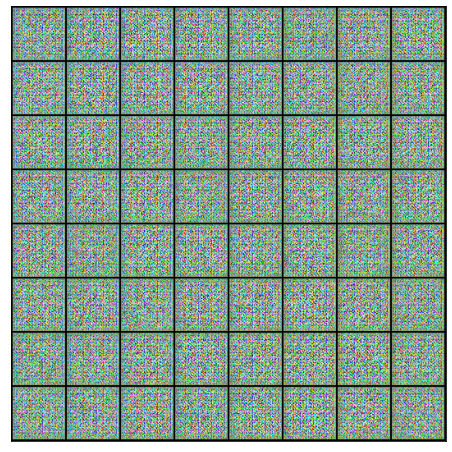

In [27]:

xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [28]:
generator = to_device(generator, device)


In [29]:

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [30]:

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [31]:
from torchvision.utils import save_image


In [32]:
SAMPLE_DIR = 'ganArt'
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [33]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [34]:
FIXED_LATENT = torch.randn(64, LATENT_SIZE, 1, 1, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


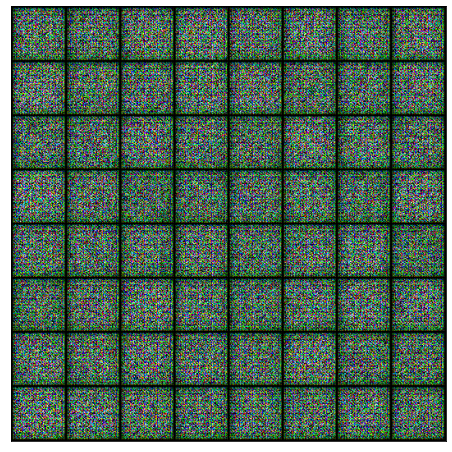

In [35]:
save_samples(0, FIXED_LATENT)


In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, FIXED_LATENT, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:

LEARNING_RATE = 0.0002
EPOCHS = 400

In [39]:
history = fit(EPOCHS, LEARNING_RATE)

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/400], loss_g: 7.0858, loss_d: 0.3182, real_score: 0.7364, fake_score: 0.0033
Saving generated-images-0001.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/400], loss_g: 6.0675, loss_d: 0.6309, real_score: 0.7371, fake_score: 0.2535
Saving generated-images-0002.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/400], loss_g: 5.3270, loss_d: 0.2275, real_score: 0.8455, fake_score: 0.0465
Saving generated-images-0003.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/400], loss_g: 1.4214, loss_d: 2.0578, real_score: 0.1510, fake_score: 0.0169
Saving generated-images-0004.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/400], loss_g: 4.2370, loss_d: 0.2345, real_score: 0.9034, fake_score: 0.1186
Saving generated-images-0005.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/400], loss_g: 4.5733, loss_d: 0.1490, real_score: 0.9512, fake_score: 0.0918
Saving generated-images-0006.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/400], loss_g: 1.8135, loss_d: 0.7376, real_score: 0.6087, fake_score: 0.0436
Saving generated-images-0007.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/400], loss_g: 5.3431, loss_d: 0.1373, real_score: 0.8974, fake_score: 0.0264
Saving generated-images-0008.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/400], loss_g: 6.2564, loss_d: 0.4697, real_score: 0.9104, fake_score: 0.2966
Saving generated-images-0009.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/400], loss_g: 3.6145, loss_d: 0.3684, real_score: 0.7674, fake_score: 0.0634
Saving generated-images-0010.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11/400], loss_g: 1.4847, loss_d: 0.7676, real_score: 0.5881, fake_score: 0.1934
Saving generated-images-0011.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12/400], loss_g: 1.8924, loss_d: 3.2888, real_score: 0.0691, fake_score: 0.0004
Saving generated-images-0012.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13/400], loss_g: 2.9258, loss_d: 1.6472, real_score: 0.3109, fake_score: 0.0145
Saving generated-images-0013.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14/400], loss_g: 4.1962, loss_d: 0.7261, real_score: 0.8357, fake_score: 0.2797
Saving generated-images-0014.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15/400], loss_g: 3.6871, loss_d: 0.4117, real_score: 0.8261, fake_score: 0.1579
Saving generated-images-0015.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16/400], loss_g: 2.4416, loss_d: 0.7865, real_score: 0.5758, fake_score: 0.1052
Saving generated-images-0016.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17/400], loss_g: 4.0222, loss_d: 0.3643, real_score: 0.9237, fake_score: 0.2349
Saving generated-images-0017.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18/400], loss_g: 1.2480, loss_d: 0.8064, real_score: 0.5363, fake_score: 0.1445
Saving generated-images-0018.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19/400], loss_g: 1.1312, loss_d: 1.1228, real_score: 0.4252, fake_score: 0.1586
Saving generated-images-0019.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [20/400], loss_g: 2.8034, loss_d: 0.6573, real_score: 0.6481, fake_score: 0.1186
Saving generated-images-0020.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [21/400], loss_g: 6.6469, loss_d: 0.8522, real_score: 0.9546, fake_score: 0.4720
Saving generated-images-0021.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [22/400], loss_g: 1.5331, loss_d: 1.1448, real_score: 0.4121, fake_score: 0.0820
Saving generated-images-0022.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [23/400], loss_g: 1.5349, loss_d: 0.8868, real_score: 0.5033, fake_score: 0.0763
Saving generated-images-0023.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [24/400], loss_g: 1.9659, loss_d: 0.5645, real_score: 0.7359, fake_score: 0.1819
Saving generated-images-0024.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [25/400], loss_g: 3.1842, loss_d: 0.3443, real_score: 0.7654, fake_score: 0.0565
Saving generated-images-0025.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [26/400], loss_g: 1.5503, loss_d: 0.8726, real_score: 0.6869, fake_score: 0.3465
Saving generated-images-0026.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [27/400], loss_g: 1.5211, loss_d: 0.6614, real_score: 0.5996, fake_score: 0.1007
Saving generated-images-0027.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [28/400], loss_g: 4.9883, loss_d: 0.5563, real_score: 0.8655, fake_score: 0.3164
Saving generated-images-0028.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [29/400], loss_g: 7.8672, loss_d: 1.7652, real_score: 0.7620, fake_score: 0.7247
Saving generated-images-0029.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [30/400], loss_g: 5.5461, loss_d: 0.6134, real_score: 0.9234, fake_score: 0.3678
Saving generated-images-0030.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [31/400], loss_g: 0.8912, loss_d: 2.9433, real_score: 0.0818, fake_score: 0.0129
Saving generated-images-0031.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [32/400], loss_g: 1.8845, loss_d: 0.9633, real_score: 0.4576, fake_score: 0.0421
Saving generated-images-0032.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [33/400], loss_g: 1.6167, loss_d: 0.9713, real_score: 0.5624, fake_score: 0.2657
Saving generated-images-0033.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [34/400], loss_g: 1.6063, loss_d: 3.0303, real_score: 0.0666, fake_score: 0.0100
Saving generated-images-0034.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [35/400], loss_g: 4.3562, loss_d: 0.3357, real_score: 0.9020, fake_score: 0.1743
Saving generated-images-0035.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [36/400], loss_g: 2.2611, loss_d: 0.9670, real_score: 0.6436, fake_score: 0.3688
Saving generated-images-0036.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [37/400], loss_g: 4.9075, loss_d: 0.8474, real_score: 0.8273, fake_score: 0.4314
Saving generated-images-0037.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [38/400], loss_g: 3.8873, loss_d: 0.6879, real_score: 0.8325, fake_score: 0.3485
Saving generated-images-0038.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [39/400], loss_g: 3.7015, loss_d: 0.3448, real_score: 0.8464, fake_score: 0.1471
Saving generated-images-0039.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [40/400], loss_g: 3.1523, loss_d: 0.8337, real_score: 0.7172, fake_score: 0.3418
Saving generated-images-0040.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [41/400], loss_g: 4.1588, loss_d: 0.6065, real_score: 0.6188, fake_score: 0.0163
Saving generated-images-0041.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [42/400], loss_g: 4.8956, loss_d: 0.7342, real_score: 0.8173, fake_score: 0.3620
Saving generated-images-0042.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [43/400], loss_g: 2.9351, loss_d: 0.5179, real_score: 0.6864, fake_score: 0.0786
Saving generated-images-0043.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [44/400], loss_g: 4.8218, loss_d: 0.3672, real_score: 0.7833, fake_score: 0.1001
Saving generated-images-0044.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [45/400], loss_g: 3.4878, loss_d: 0.4163, real_score: 0.8124, fake_score: 0.1546
Saving generated-images-0045.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [46/400], loss_g: 4.8545, loss_d: 0.9952, real_score: 0.8530, fake_score: 0.5055
Saving generated-images-0046.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [47/400], loss_g: 5.7711, loss_d: 0.5200, real_score: 0.8477, fake_score: 0.2725
Saving generated-images-0047.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [48/400], loss_g: 4.6632, loss_d: 0.2808, real_score: 0.8851, fake_score: 0.1363
Saving generated-images-0048.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [49/400], loss_g: 1.8679, loss_d: 1.0976, real_score: 0.4587, fake_score: 0.0427
Saving generated-images-0049.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [50/400], loss_g: 5.2229, loss_d: 0.6430, real_score: 0.9024, fake_score: 0.3835
Saving generated-images-0050.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [51/400], loss_g: 2.7124, loss_d: 0.4658, real_score: 0.7627, fake_score: 0.1411
Saving generated-images-0051.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [52/400], loss_g: 4.1274, loss_d: 0.3429, real_score: 0.9189, fake_score: 0.2101
Saving generated-images-0052.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [53/400], loss_g: 3.3581, loss_d: 0.7687, real_score: 0.6895, fake_score: 0.1637
Saving generated-images-0053.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [54/400], loss_g: 5.6285, loss_d: 0.2682, real_score: 0.9624, fake_score: 0.1845
Saving generated-images-0054.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [55/400], loss_g: 0.6363, loss_d: 1.0992, real_score: 0.4246, fake_score: 0.1894
Saving generated-images-0055.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [56/400], loss_g: 4.9798, loss_d: 0.5298, real_score: 0.9635, fake_score: 0.3525
Saving generated-images-0056.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [57/400], loss_g: 1.6611, loss_d: 1.1145, real_score: 0.3798, fake_score: 0.0106
Saving generated-images-0057.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [58/400], loss_g: 4.9832, loss_d: 0.2234, real_score: 0.8578, fake_score: 0.0558
Saving generated-images-0058.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [59/400], loss_g: 3.2335, loss_d: 0.3426, real_score: 0.8484, fake_score: 0.1499
Saving generated-images-0059.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [60/400], loss_g: 1.2671, loss_d: 1.3396, real_score: 0.4804, fake_score: 0.2795
Saving generated-images-0060.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [61/400], loss_g: 5.1528, loss_d: 0.9739, real_score: 0.7713, fake_score: 0.4505
Saving generated-images-0061.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [62/400], loss_g: 3.8560, loss_d: 0.3830, real_score: 0.8673, fake_score: 0.1932
Saving generated-images-0062.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [63/400], loss_g: 3.1757, loss_d: 0.3542, real_score: 0.7499, fake_score: 0.0369
Saving generated-images-0063.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [64/400], loss_g: 2.0364, loss_d: 0.9088, real_score: 0.5791, fake_score: 0.1792
Saving generated-images-0064.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [65/400], loss_g: 4.5933, loss_d: 0.5156, real_score: 0.8495, fake_score: 0.2697
Saving generated-images-0065.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [66/400], loss_g: 3.9586, loss_d: 0.1975, real_score: 0.8998, fake_score: 0.0727
Saving generated-images-0066.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [67/400], loss_g: 8.5635, loss_d: 1.6161, real_score: 0.9782, fake_score: 0.7281
Saving generated-images-0067.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [68/400], loss_g: 0.3102, loss_d: 1.9550, real_score: 0.2204, fake_score: 0.1411
Saving generated-images-0068.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [69/400], loss_g: 4.1339, loss_d: 0.3179, real_score: 0.8126, fake_score: 0.0892
Saving generated-images-0069.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [70/400], loss_g: 0.3842, loss_d: 2.0093, real_score: 0.1976, fake_score: 0.0605
Saving generated-images-0070.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [71/400], loss_g: 0.8117, loss_d: 1.4855, real_score: 0.3546, fake_score: 0.1802
Saving generated-images-0071.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [72/400], loss_g: 2.8669, loss_d: 0.8307, real_score: 0.7400, fake_score: 0.3632
Saving generated-images-0072.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [73/400], loss_g: 4.2795, loss_d: 0.2957, real_score: 0.8198, fake_score: 0.0523
Saving generated-images-0073.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [74/400], loss_g: 0.5704, loss_d: 1.8078, real_score: 0.2091, fake_score: 0.0386
Saving generated-images-0074.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [75/400], loss_g: 2.9828, loss_d: 0.6421, real_score: 0.7433, fake_score: 0.2534
Saving generated-images-0075.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [76/400], loss_g: 3.5735, loss_d: 0.2453, real_score: 0.8626, fake_score: 0.0632
Saving generated-images-0076.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [77/400], loss_g: 3.2985, loss_d: 0.6620, real_score: 0.8288, fake_score: 0.3314
Saving generated-images-0077.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [78/400], loss_g: 3.6817, loss_d: 0.3961, real_score: 0.8275, fake_score: 0.1701
Saving generated-images-0078.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [79/400], loss_g: 4.7764, loss_d: 0.3831, real_score: 0.9552, fake_score: 0.2632
Saving generated-images-0079.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [80/400], loss_g: 1.4104, loss_d: 0.5850, real_score: 0.6855, fake_score: 0.1398
Saving generated-images-0080.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [81/400], loss_g: 0.6308, loss_d: 0.9883, real_score: 0.4461, fake_score: 0.0444
Saving generated-images-0081.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [82/400], loss_g: 3.6111, loss_d: 0.2069, real_score: 0.8811, fake_score: 0.0747
Saving generated-images-0082.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [83/400], loss_g: 1.6305, loss_d: 0.6061, real_score: 0.6240, fake_score: 0.0636
Saving generated-images-0083.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [84/400], loss_g: 4.4127, loss_d: 0.4615, real_score: 0.8974, fake_score: 0.2770
Saving generated-images-0084.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [85/400], loss_g: 0.1622, loss_d: 0.6432, real_score: 0.6226, fake_score: 0.1250
Saving generated-images-0085.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [86/400], loss_g: 1.6204, loss_d: 1.1795, real_score: 0.5202, fake_score: 0.3279
Saving generated-images-0086.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [87/400], loss_g: 1.7783, loss_d: 0.8429, real_score: 0.5741, fake_score: 0.1214
Saving generated-images-0087.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [88/400], loss_g: 1.1200, loss_d: 0.6491, real_score: 0.6021, fake_score: 0.0850
Saving generated-images-0088.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [89/400], loss_g: 4.4042, loss_d: 0.5627, real_score: 0.8522, fake_score: 0.3055
Saving generated-images-0089.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [90/400], loss_g: 1.3340, loss_d: 0.3823, real_score: 0.7890, fake_score: 0.1219
Saving generated-images-0090.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [91/400], loss_g: 2.5399, loss_d: 0.4554, real_score: 0.7540, fake_score: 0.1371
Saving generated-images-0091.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [92/400], loss_g: 0.1511, loss_d: 1.0949, real_score: 0.4409, fake_score: 0.1107
Saving generated-images-0092.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [93/400], loss_g: 3.6477, loss_d: 0.5428, real_score: 0.7374, fake_score: 0.1370
Saving generated-images-0093.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [94/400], loss_g: 0.4049, loss_d: 1.5934, real_score: 0.3549, fake_score: 0.2807
Saving generated-images-0094.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [95/400], loss_g: 2.3222, loss_d: 0.5616, real_score: 0.7181, fake_score: 0.1205
Saving generated-images-0095.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [96/400], loss_g: 0.9842, loss_d: 1.0105, real_score: 0.5222, fake_score: 0.1544
Saving generated-images-0096.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [97/400], loss_g: 4.0627, loss_d: 0.3571, real_score: 0.8649, fake_score: 0.1761
Saving generated-images-0097.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [98/400], loss_g: 1.3676, loss_d: 0.9239, real_score: 0.5049, fake_score: 0.0634
Saving generated-images-0098.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [99/400], loss_g: 1.3151, loss_d: 1.0120, real_score: 0.5519, fake_score: 0.2728
Saving generated-images-0099.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [100/400], loss_g: 0.4515, loss_d: 1.0525, real_score: 0.4205, fake_score: 0.0532
Saving generated-images-0100.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [101/400], loss_g: 0.6830, loss_d: 0.7279, real_score: 0.5906, fake_score: 0.1374
Saving generated-images-0101.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [102/400], loss_g: 1.3456, loss_d: 0.5251, real_score: 0.6798, fake_score: 0.1175
Saving generated-images-0102.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [103/400], loss_g: 1.1359, loss_d: 0.6788, real_score: 0.5456, fake_score: 0.0580
Saving generated-images-0103.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [104/400], loss_g: 0.2649, loss_d: 1.3423, real_score: 0.4047, fake_score: 0.1269
Saving generated-images-0104.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [105/400], loss_g: 1.1039, loss_d: 0.7336, real_score: 0.5535, fake_score: 0.0875
Saving generated-images-0105.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [106/400], loss_g: 0.1308, loss_d: 1.5353, real_score: 0.3122, fake_score: 0.0601
Saving generated-images-0106.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [107/400], loss_g: 0.0780, loss_d: 2.7206, real_score: 0.1326, fake_score: 0.0972
Saving generated-images-0107.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [108/400], loss_g: 5.2655, loss_d: 0.4940, real_score: 0.8716, fake_score: 0.2710
Saving generated-images-0108.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [109/400], loss_g: 3.7020, loss_d: 0.1601, real_score: 0.9076, fake_score: 0.0576
Saving generated-images-0109.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [110/400], loss_g: 0.1304, loss_d: 1.7957, real_score: 0.3369, fake_score: 0.3272
Saving generated-images-0110.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [111/400], loss_g: 2.9690, loss_d: 0.3858, real_score: 0.8104, fake_score: 0.1492
Saving generated-images-0111.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [112/400], loss_g: 0.4889, loss_d: 0.8780, real_score: 0.4964, fake_score: 0.1043
Saving generated-images-0112.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [113/400], loss_g: 4.4762, loss_d: 0.2694, real_score: 0.9199, fake_score: 0.1550
Saving generated-images-0113.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [114/400], loss_g: 3.4112, loss_d: 0.9743, real_score: 0.7257, fake_score: 0.4324
Saving generated-images-0114.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [115/400], loss_g: 4.0799, loss_d: 0.3850, real_score: 0.8363, fake_score: 0.1652
Saving generated-images-0115.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [116/400], loss_g: 2.2738, loss_d: 0.3499, real_score: 0.7971, fake_score: 0.0856
Saving generated-images-0116.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [117/400], loss_g: 2.7162, loss_d: 0.6244, real_score: 0.7157, fake_score: 0.1724
Saving generated-images-0117.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [118/400], loss_g: 1.8532, loss_d: 0.5019, real_score: 0.6958, fake_score: 0.1009
Saving generated-images-0118.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [119/400], loss_g: 3.5108, loss_d: 0.4943, real_score: 0.6913, fake_score: 0.0278
Saving generated-images-0119.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [120/400], loss_g: 3.1263, loss_d: 0.5020, real_score: 0.7866, fake_score: 0.1826
Saving generated-images-0120.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [121/400], loss_g: 0.6558, loss_d: 1.1441, real_score: 0.4824, fake_score: 0.2274
Saving generated-images-0121.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [122/400], loss_g: 1.3443, loss_d: 0.8987, real_score: 0.6064, fake_score: 0.2527
Saving generated-images-0122.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [123/400], loss_g: 1.1396, loss_d: 0.8011, real_score: 0.5656, fake_score: 0.1485
Saving generated-images-0123.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [124/400], loss_g: 3.3152, loss_d: 0.3900, real_score: 0.7546, fake_score: 0.0923
Saving generated-images-0124.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [125/400], loss_g: 2.0305, loss_d: 0.5572, real_score: 0.6636, fake_score: 0.1105
Saving generated-images-0125.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [126/400], loss_g: 5.6339, loss_d: 0.4238, real_score: 0.9515, fake_score: 0.2842
Saving generated-images-0126.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [127/400], loss_g: 3.2845, loss_d: 0.2228, real_score: 0.9116, fake_score: 0.1111
Saving generated-images-0127.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [128/400], loss_g: 3.1023, loss_d: 0.2903, real_score: 0.8392, fake_score: 0.0955
Saving generated-images-0128.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [129/400], loss_g: 5.2480, loss_d: 0.1512, real_score: 0.9811, fake_score: 0.1172
Saving generated-images-0129.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [130/400], loss_g: 2.0508, loss_d: 0.4958, real_score: 0.7541, fake_score: 0.1637
Saving generated-images-0130.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [131/400], loss_g: 4.7422, loss_d: 0.5487, real_score: 0.8624, fake_score: 0.2917
Saving generated-images-0131.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [132/400], loss_g: 5.7089, loss_d: 0.3997, real_score: 0.9880, fake_score: 0.2909
Saving generated-images-0132.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [133/400], loss_g: 2.4512, loss_d: 0.5937, real_score: 0.7717, fake_score: 0.2302
Saving generated-images-0133.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [134/400], loss_g: 0.1548, loss_d: 0.8678, real_score: 0.4916, fake_score: 0.0743
Saving generated-images-0134.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [135/400], loss_g: 4.3164, loss_d: 0.1789, real_score: 0.9156, fake_score: 0.0796
Saving generated-images-0135.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [136/400], loss_g: 2.4583, loss_d: 0.3792, real_score: 0.7635, fake_score: 0.0803
Saving generated-images-0136.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [137/400], loss_g: 3.4548, loss_d: 0.3364, real_score: 0.8559, fake_score: 0.1498
Saving generated-images-0137.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [138/400], loss_g: 0.6389, loss_d: 0.6400, real_score: 0.6036, fake_score: 0.0683
Saving generated-images-0138.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [139/400], loss_g: 2.0248, loss_d: 0.4946, real_score: 0.6533, fake_score: 0.0434
Saving generated-images-0139.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [140/400], loss_g: 4.2153, loss_d: 0.2683, real_score: 0.8588, fake_score: 0.1001
Saving generated-images-0140.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [141/400], loss_g: 0.3053, loss_d: 0.9315, real_score: 0.4843, fake_score: 0.1330
Saving generated-images-0141.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [142/400], loss_g: 3.2147, loss_d: 0.3615, real_score: 0.7676, fake_score: 0.0611
Saving generated-images-0142.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [143/400], loss_g: 2.9112, loss_d: 0.2436, real_score: 0.8456, fake_score: 0.0601
Saving generated-images-0143.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [144/400], loss_g: 0.0466, loss_d: 1.4439, real_score: 0.3753, fake_score: 0.1399
Saving generated-images-0144.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [145/400], loss_g: 0.0652, loss_d: 1.8517, real_score: 0.2264, fake_score: 0.1071
Saving generated-images-0145.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [146/400], loss_g: 2.7776, loss_d: 0.4556, real_score: 0.7999, fake_score: 0.1809
Saving generated-images-0146.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [147/400], loss_g: 1.3212, loss_d: 0.7769, real_score: 0.6263, fake_score: 0.2101
Saving generated-images-0147.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [148/400], loss_g: 0.0276, loss_d: 1.8994, real_score: 0.2799, fake_score: 0.0696
Saving generated-images-0148.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [149/400], loss_g: 4.3295, loss_d: 0.6427, real_score: 0.8316, fake_score: 0.3185
Saving generated-images-0149.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [150/400], loss_g: 0.0188, loss_d: 1.8573, real_score: 0.2187, fake_score: 0.1452
Saving generated-images-0150.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [151/400], loss_g: 2.6991, loss_d: 0.4212, real_score: 0.7934, fake_score: 0.1411
Saving generated-images-0151.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [152/400], loss_g: 2.4733, loss_d: 0.4676, real_score: 0.7654, fake_score: 0.1605
Saving generated-images-0152.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [153/400], loss_g: 4.5681, loss_d: 0.2036, real_score: 0.9798, fake_score: 0.1591
Saving generated-images-0153.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [154/400], loss_g: 1.5932, loss_d: 0.3441, real_score: 0.8050, fake_score: 0.1035
Saving generated-images-0154.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [155/400], loss_g: 2.4338, loss_d: 0.3233, real_score: 0.7672, fake_score: 0.0451
Saving generated-images-0155.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [156/400], loss_g: 3.5953, loss_d: 0.4438, real_score: 0.8530, fake_score: 0.2257
Saving generated-images-0156.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [157/400], loss_g: 2.1464, loss_d: 0.3726, real_score: 0.7811, fake_score: 0.1067
Saving generated-images-0157.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [158/400], loss_g: 0.8040, loss_d: 0.7442, real_score: 0.5615, fake_score: 0.0736
Saving generated-images-0158.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [159/400], loss_g: 4.0127, loss_d: 0.2993, real_score: 0.8687, fake_score: 0.1133
Saving generated-images-0159.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [160/400], loss_g: 5.3424, loss_d: 0.2155, real_score: 0.8347, fake_score: 0.0161
Saving generated-images-0160.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [161/400], loss_g: 5.3371, loss_d: 0.1460, real_score: 0.8915, fake_score: 0.0210
Saving generated-images-0161.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [162/400], loss_g: 3.9586, loss_d: 0.4792, real_score: 0.8222, fake_score: 0.2237
Saving generated-images-0162.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [163/400], loss_g: 2.5466, loss_d: 0.2703, real_score: 0.8348, fake_score: 0.0718
Saving generated-images-0163.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [164/400], loss_g: 3.8456, loss_d: 0.2484, real_score: 0.9011, fake_score: 0.1185
Saving generated-images-0164.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [165/400], loss_g: 5.4480, loss_d: 0.1435, real_score: 0.9915, fake_score: 0.1175
Saving generated-images-0165.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [166/400], loss_g: 1.4263, loss_d: 0.4585, real_score: 0.6756, fake_score: 0.0454
Saving generated-images-0166.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [167/400], loss_g: 8.6623, loss_d: 0.1845, real_score: 0.8397, fake_score: 0.0019
Saving generated-images-0167.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [168/400], loss_g: 0.0236, loss_d: 1.7616, real_score: 0.2686, fake_score: 0.1514
Saving generated-images-0168.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [169/400], loss_g: 2.7365, loss_d: 0.3127, real_score: 0.8217, fake_score: 0.0979
Saving generated-images-0169.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [170/400], loss_g: 0.7851, loss_d: 0.6989, real_score: 0.5752, fake_score: 0.0739
Saving generated-images-0170.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [171/400], loss_g: 1.6785, loss_d: 0.6688, real_score: 0.6002, fake_score: 0.0534
Saving generated-images-0171.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [172/400], loss_g: 4.0217, loss_d: 0.1805, real_score: 0.9223, fake_score: 0.0865
Saving generated-images-0172.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [173/400], loss_g: 1.9555, loss_d: 0.4158, real_score: 0.7189, fake_score: 0.0506
Saving generated-images-0173.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [174/400], loss_g: 3.3253, loss_d: 0.5537, real_score: 0.6345, fake_score: 0.0140
Saving generated-images-0174.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [175/400], loss_g: 4.9571, loss_d: 0.1409, real_score: 0.8960, fake_score: 0.0224
Saving generated-images-0175.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [176/400], loss_g: 4.8953, loss_d: 0.1443, real_score: 0.9451, fake_score: 0.0769
Saving generated-images-0176.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [177/400], loss_g: 5.5953, loss_d: 0.1738, real_score: 0.9214, fake_score: 0.0793
Saving generated-images-0177.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [178/400], loss_g: 0.0243, loss_d: 1.1107, real_score: 0.4370, fake_score: 0.0425
Saving generated-images-0178.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [179/400], loss_g: 2.4948, loss_d: 0.4390, real_score: 0.7104, fake_score: 0.0424
Saving generated-images-0179.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [180/400], loss_g: 0.0098, loss_d: 1.2484, real_score: 0.4326, fake_score: 0.0696
Saving generated-images-0180.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [181/400], loss_g: 2.9744, loss_d: 0.1902, real_score: 0.8767, fake_score: 0.0363
Saving generated-images-0181.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [182/400], loss_g: 3.4509, loss_d: 0.6184, real_score: 0.7172, fake_score: 0.1853
Saving generated-images-0182.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [183/400], loss_g: 0.2177, loss_d: 0.9424, real_score: 0.4906, fake_score: 0.1247
Saving generated-images-0183.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [184/400], loss_g: 4.0877, loss_d: 0.1839, real_score: 0.9538, fake_score: 0.1141
Saving generated-images-0184.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [185/400], loss_g: 1.2133, loss_d: 0.7788, real_score: 0.5838, fake_score: 0.1107
Saving generated-images-0185.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [186/400], loss_g: 1.5037, loss_d: 0.5225, real_score: 0.6454, fake_score: 0.0415
Saving generated-images-0186.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [187/400], loss_g: 0.0094, loss_d: 3.0629, real_score: 0.1169, fake_score: 0.0736
Saving generated-images-0187.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [188/400], loss_g: 5.1018, loss_d: 0.1187, real_score: 0.9425, fake_score: 0.0525
Saving generated-images-0188.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [189/400], loss_g: 0.3221, loss_d: 1.0589, real_score: 0.4199, fake_score: 0.1019
Saving generated-images-0189.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [190/400], loss_g: 2.6875, loss_d: 0.4540, real_score: 0.7439, fake_score: 0.0823
Saving generated-images-0190.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [191/400], loss_g: 4.1602, loss_d: 0.1645, real_score: 0.9847, fake_score: 0.1278
Saving generated-images-0191.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [192/400], loss_g: 3.8954, loss_d: 0.1418, real_score: 0.9090, fake_score: 0.0417
Saving generated-images-0192.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [193/400], loss_g: 4.7943, loss_d: 0.1133, real_score: 0.9372, fake_score: 0.0436
Saving generated-images-0193.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [194/400], loss_g: 1.7211, loss_d: 0.4547, real_score: 0.6926, fake_score: 0.0243
Saving generated-images-0194.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [195/400], loss_g: 3.3238, loss_d: 0.1792, real_score: 0.8876, fake_score: 0.0542
Saving generated-images-0195.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [196/400], loss_g: 6.2106, loss_d: 0.4004, real_score: 0.9762, fake_score: 0.2885
Saving generated-images-0196.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [197/400], loss_g: 1.6769, loss_d: 0.3759, real_score: 0.7725, fake_score: 0.0511
Saving generated-images-0197.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [198/400], loss_g: 4.0295, loss_d: 0.1873, real_score: 0.8776, fake_score: 0.0446
Saving generated-images-0198.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [199/400], loss_g: 1.1828, loss_d: 0.5140, real_score: 0.6874, fake_score: 0.0591
Saving generated-images-0199.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [200/400], loss_g: 3.8299, loss_d: 0.5068, real_score: 0.8070, fake_score: 0.1745
Saving generated-images-0200.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [201/400], loss_g: 2.3261, loss_d: 3.0661, real_score: 0.0630, fake_score: 0.0005
Saving generated-images-0201.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [202/400], loss_g: 0.2054, loss_d: 1.6000, real_score: 0.2908, fake_score: 0.0679
Saving generated-images-0202.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [203/400], loss_g: 4.4425, loss_d: 0.1099, real_score: 0.9786, fake_score: 0.0789
Saving generated-images-0203.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [204/400], loss_g: 3.1335, loss_d: 0.3413, real_score: 0.8570, fake_score: 0.1456
Saving generated-images-0204.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [205/400], loss_g: 0.5380, loss_d: 0.9725, real_score: 0.4853, fake_score: 0.0763
Saving generated-images-0205.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [206/400], loss_g: 4.4482, loss_d: 0.2116, real_score: 0.9047, fake_score: 0.0887
Saving generated-images-0206.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [207/400], loss_g: 0.0054, loss_d: 2.1098, real_score: 0.1746, fake_score: 0.0920
Saving generated-images-0207.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [208/400], loss_g: 3.3150, loss_d: 0.4799, real_score: 0.8114, fake_score: 0.1589
Saving generated-images-0208.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [209/400], loss_g: 1.1217, loss_d: 0.9161, real_score: 0.5933, fake_score: 0.0347
Saving generated-images-0209.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [210/400], loss_g: 3.5172, loss_d: 0.1945, real_score: 0.8900, fake_score: 0.0584
Saving generated-images-0210.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [211/400], loss_g: 3.0154, loss_d: 0.2385, real_score: 0.8770, fake_score: 0.0936
Saving generated-images-0211.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [212/400], loss_g: 0.0482, loss_d: 1.9423, real_score: 0.3048, fake_score: 0.0684
Saving generated-images-0212.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [213/400], loss_g: 0.9115, loss_d: 1.0498, real_score: 0.5171, fake_score: 0.1575
Saving generated-images-0213.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [214/400], loss_g: 2.5026, loss_d: 0.7493, real_score: 0.6408, fake_score: 0.0430
Saving generated-images-0214.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [215/400], loss_g: 4.2322, loss_d: 0.1860, real_score: 0.8943, fake_score: 0.0659
Saving generated-images-0215.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [216/400], loss_g: 1.0611, loss_d: 0.5905, real_score: 0.6454, fake_score: 0.0428
Saving generated-images-0216.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [217/400], loss_g: 3.7637, loss_d: 0.1700, real_score: 0.9273, fake_score: 0.0834
Saving generated-images-0217.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [218/400], loss_g: 4.0940, loss_d: 0.1278, real_score: 0.9254, fake_score: 0.0460
Saving generated-images-0218.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [219/400], loss_g: 0.7739, loss_d: 0.8970, real_score: 0.5377, fake_score: 0.1604
Saving generated-images-0219.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [220/400], loss_g: 3.1346, loss_d: 0.3774, real_score: 0.8168, fake_score: 0.1198
Saving generated-images-0220.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [221/400], loss_g: 3.3250, loss_d: 0.3480, real_score: 0.8493, fake_score: 0.1395
Saving generated-images-0221.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [222/400], loss_g: 4.9335, loss_d: 0.1068, real_score: 0.9362, fake_score: 0.0369
Saving generated-images-0222.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [223/400], loss_g: 0.3838, loss_d: 0.6664, real_score: 0.5963, fake_score: 0.0414
Saving generated-images-0223.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [224/400], loss_g: 3.9930, loss_d: 0.2649, real_score: 0.9068, fake_score: 0.1311
Saving generated-images-0224.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [225/400], loss_g: 0.9094, loss_d: 0.6757, real_score: 0.5874, fake_score: 0.0560
Saving generated-images-0225.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [226/400], loss_g: 2.1041, loss_d: 0.4166, real_score: 0.7973, fake_score: 0.1298
Saving generated-images-0226.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [227/400], loss_g: 5.3409, loss_d: 0.1831, real_score: 0.9572, fake_score: 0.1169
Saving generated-images-0227.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [228/400], loss_g: 4.6373, loss_d: 0.1493, real_score: 0.9763, fake_score: 0.1082
Saving generated-images-0228.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [229/400], loss_g: 5.1505, loss_d: 0.1579, real_score: 0.9420, fake_score: 0.0842
Saving generated-images-0229.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [230/400], loss_g: 3.9743, loss_d: 0.2049, real_score: 0.8651, fake_score: 0.0476
Saving generated-images-0230.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [231/400], loss_g: 0.0290, loss_d: 0.8593, real_score: 0.4968, fake_score: 0.0684
Saving generated-images-0231.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [232/400], loss_g: 1.7078, loss_d: 0.5470, real_score: 0.6499, fake_score: 0.0538
Saving generated-images-0232.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [233/400], loss_g: 0.0838, loss_d: 2.0622, real_score: 0.2224, fake_score: 0.0551
Saving generated-images-0233.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [234/400], loss_g: 1.4973, loss_d: 0.7914, real_score: 0.6340, fake_score: 0.1039
Saving generated-images-0234.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [235/400], loss_g: 4.3747, loss_d: 0.1496, real_score: 0.9589, fake_score: 0.0939
Saving generated-images-0235.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [236/400], loss_g: 1.3440, loss_d: 0.6077, real_score: 0.6707, fake_score: 0.1030
Saving generated-images-0236.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [237/400], loss_g: 3.8452, loss_d: 0.2473, real_score: 0.8850, fake_score: 0.1009
Saving generated-images-0237.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [238/400], loss_g: 1.0851, loss_d: 0.6113, real_score: 0.6310, fake_score: 0.0470
Saving generated-images-0238.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [239/400], loss_g: 4.8859, loss_d: 0.4346, real_score: 0.8999, fake_score: 0.2516
Saving generated-images-0239.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [240/400], loss_g: 0.6584, loss_d: 0.7440, real_score: 0.5273, fake_score: 0.0509
Saving generated-images-0240.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [241/400], loss_g: 2.5788, loss_d: 0.3893, real_score: 0.7933, fake_score: 0.0662
Saving generated-images-0241.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [242/400], loss_g: 1.1200, loss_d: 0.5702, real_score: 0.6741, fake_score: 0.1200
Saving generated-images-0242.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [243/400], loss_g: 2.5740, loss_d: 0.7278, real_score: 0.6562, fake_score: 0.2027
Saving generated-images-0243.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [244/400], loss_g: 4.3828, loss_d: 0.0811, real_score: 0.9980, fake_score: 0.0716
Saving generated-images-0244.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [245/400], loss_g: 4.9975, loss_d: 0.0791, real_score: 0.9653, fake_score: 0.0415
Saving generated-images-0245.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [246/400], loss_g: 0.0713, loss_d: 1.5138, real_score: 0.3248, fake_score: 0.0543
Saving generated-images-0246.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [247/400], loss_g: 3.5545, loss_d: 0.4362, real_score: 0.8275, fake_score: 0.1027
Saving generated-images-0247.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [248/400], loss_g: 1.0859, loss_d: 0.5377, real_score: 0.6778, fake_score: 0.0718
Saving generated-images-0248.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [249/400], loss_g: 3.3483, loss_d: 0.2919, real_score: 0.8175, fake_score: 0.0338
Saving generated-images-0249.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [250/400], loss_g: 3.6311, loss_d: 0.2489, real_score: 0.8927, fake_score: 0.1125
Saving generated-images-0250.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [251/400], loss_g: 4.3912, loss_d: 0.1875, real_score: 0.9425, fake_score: 0.1113
Saving generated-images-0251.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [252/400], loss_g: 1.3066, loss_d: 0.3772, real_score: 0.7259, fake_score: 0.0283
Saving generated-images-0252.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [253/400], loss_g: 0.0309, loss_d: 1.3261, real_score: 0.3770, fake_score: 0.0440
Saving generated-images-0253.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [254/400], loss_g: 4.0846, loss_d: 0.4152, real_score: 0.8564, fake_score: 0.1791
Saving generated-images-0254.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [255/400], loss_g: 2.5797, loss_d: 0.2995, real_score: 0.7727, fake_score: 0.0279
Saving generated-images-0255.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [256/400], loss_g: 0.5511, loss_d: 0.9107, real_score: 0.4455, fake_score: 0.0106
Saving generated-images-0256.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [257/400], loss_g: 4.8912, loss_d: 0.1845, real_score: 0.9362, fake_score: 0.1025
Saving generated-images-0257.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [258/400], loss_g: 0.8799, loss_d: 0.7161, real_score: 0.5632, fake_score: 0.0462
Saving generated-images-0258.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [259/400], loss_g: 4.9240, loss_d: 0.1102, real_score: 0.9543, fake_score: 0.0583
Saving generated-images-0259.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [260/400], loss_g: 0.0082, loss_d: 1.8015, real_score: 0.2298, fake_score: 0.0394
Saving generated-images-0260.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [261/400], loss_g: 0.8597, loss_d: 1.0808, real_score: 0.4861, fake_score: 0.0823
Saving generated-images-0261.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [262/400], loss_g: 0.1616, loss_d: 1.7476, real_score: 0.2595, fake_score: 0.0286
Saving generated-images-0262.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [263/400], loss_g: 3.8378, loss_d: 0.2403, real_score: 0.8948, fake_score: 0.1034
Saving generated-images-0263.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [264/400], loss_g: 2.4254, loss_d: 0.4450, real_score: 0.7160, fake_score: 0.0741
Saving generated-images-0264.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [265/400], loss_g: 0.1617, loss_d: 1.1355, real_score: 0.3957, fake_score: 0.0385
Saving generated-images-0265.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [266/400], loss_g: 3.2790, loss_d: 0.3037, real_score: 0.8092, fake_score: 0.0313
Saving generated-images-0266.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [267/400], loss_g: 2.9547, loss_d: 0.2583, real_score: 0.8419, fake_score: 0.0408
Saving generated-images-0267.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [268/400], loss_g: 4.6328, loss_d: 0.0886, real_score: 0.9654, fake_score: 0.0490
Saving generated-images-0268.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [269/400], loss_g: 2.7127, loss_d: 0.3270, real_score: 0.7877, fake_score: 0.0722
Saving generated-images-0269.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [270/400], loss_g: 4.8559, loss_d: 0.0836, real_score: 0.9598, fake_score: 0.0393
Saving generated-images-0270.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [271/400], loss_g: 2.6801, loss_d: 0.3997, real_score: 0.7768, fake_score: 0.0983
Saving generated-images-0271.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [272/400], loss_g: 3.9262, loss_d: 0.1201, real_score: 0.9535, fake_score: 0.0646
Saving generated-images-0272.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [273/400], loss_g: 0.0046, loss_d: 2.7619, real_score: 0.1830, fake_score: 0.0667
Saving generated-images-0273.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [274/400], loss_g: 4.2416, loss_d: 0.3042, real_score: 0.8924, fake_score: 0.1463
Saving generated-images-0274.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [275/400], loss_g: 1.0038, loss_d: 1.2409, real_score: 0.4796, fake_score: 0.0218
Saving generated-images-0275.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [276/400], loss_g: 4.9929, loss_d: 0.0724, real_score: 0.9945, fake_score: 0.0590
Saving generated-images-0276.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [277/400], loss_g: 4.0551, loss_d: 0.0930, real_score: 0.9812, fake_score: 0.0673
Saving generated-images-0277.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [278/400], loss_g: 4.9772, loss_d: 0.2170, real_score: 0.9803, fake_score: 0.1580
Saving generated-images-0278.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [279/400], loss_g: 4.3048, loss_d: 0.2599, real_score: 0.8953, fake_score: 0.1216
Saving generated-images-0279.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [280/400], loss_g: 4.7429, loss_d: 0.1129, real_score: 0.9827, fake_score: 0.0850
Saving generated-images-0280.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [281/400], loss_g: 3.9344, loss_d: 0.1459, real_score: 0.8877, fake_score: 0.0213
Saving generated-images-0281.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [282/400], loss_g: 0.3622, loss_d: 0.8553, real_score: 0.5626, fake_score: 0.1065
Saving generated-images-0282.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [283/400], loss_g: 4.4608, loss_d: 0.2005, real_score: 0.8627, fake_score: 0.0401
Saving generated-images-0283.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [284/400], loss_g: 3.0105, loss_d: 0.2549, real_score: 0.8679, fake_score: 0.0919
Saving generated-images-0284.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [285/400], loss_g: 3.8182, loss_d: 0.1766, real_score: 0.9057, fake_score: 0.0617
Saving generated-images-0285.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [286/400], loss_g: 0.7797, loss_d: 0.7216, real_score: 0.6292, fake_score: 0.0615
Saving generated-images-0286.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [287/400], loss_g: 4.2252, loss_d: 0.1180, real_score: 0.9175, fake_score: 0.0279
Saving generated-images-0287.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [288/400], loss_g: 5.0820, loss_d: 0.0871, real_score: 0.9845, fake_score: 0.0646
Saving generated-images-0288.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [289/400], loss_g: 0.0049, loss_d: 1.9739, real_score: 0.1791, fake_score: 0.0376
Saving generated-images-0289.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [290/400], loss_g: 3.7943, loss_d: 0.8453, real_score: 0.7097, fake_score: 0.1707
Saving generated-images-0290.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [291/400], loss_g: 4.2899, loss_d: 0.2624, real_score: 0.8387, fake_score: 0.0305
Saving generated-images-0291.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [292/400], loss_g: 3.2268, loss_d: 0.3825, real_score: 0.8162, fake_score: 0.1392
Saving generated-images-0292.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [293/400], loss_g: 2.5466, loss_d: 0.2366, real_score: 0.8435, fake_score: 0.0575
Saving generated-images-0293.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [294/400], loss_g: 0.4633, loss_d: 0.8137, real_score: 0.5530, fake_score: 0.0521
Saving generated-images-0294.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [295/400], loss_g: 4.3308, loss_d: 0.2739, real_score: 0.9150, fake_score: 0.1482
Saving generated-images-0295.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [296/400], loss_g: 2.8854, loss_d: 0.3141, real_score: 0.8001, fake_score: 0.0685
Saving generated-images-0296.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [297/400], loss_g: 1.6873, loss_d: 0.3284, real_score: 0.7716, fake_score: 0.0299
Saving generated-images-0297.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [298/400], loss_g: 2.8578, loss_d: 0.3471, real_score: 0.7930, fake_score: 0.0836
Saving generated-images-0298.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [299/400], loss_g: 4.6331, loss_d: 0.1159, real_score: 0.9103, fake_score: 0.0195
Saving generated-images-0299.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [300/400], loss_g: 3.1817, loss_d: 0.2351, real_score: 0.8335, fake_score: 0.0347
Saving generated-images-0300.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [301/400], loss_g: 0.4691, loss_d: 0.7539, real_score: 0.5437, fake_score: 0.0553
Saving generated-images-0301.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [302/400], loss_g: 0.4139, loss_d: 0.5402, real_score: 0.6114, fake_score: 0.0193
Saving generated-images-0302.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [303/400], loss_g: 6.0005, loss_d: 0.1607, real_score: 0.9851, fake_score: 0.1194
Saving generated-images-0303.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [304/400], loss_g: 0.4249, loss_d: 1.3619, real_score: 0.4288, fake_score: 0.0712
Saving generated-images-0304.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [305/400], loss_g: 6.5479, loss_d: 0.4930, real_score: 0.9205, fake_score: 0.2836
Saving generated-images-0305.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [306/400], loss_g: 1.6112, loss_d: 0.3469, real_score: 0.7701, fake_score: 0.0657
Saving generated-images-0306.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [307/400], loss_g: 4.5888, loss_d: 0.1230, real_score: 0.9346, fake_score: 0.0505
Saving generated-images-0307.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [308/400], loss_g: 2.2373, loss_d: 0.3986, real_score: 0.8055, fake_score: 0.1096
Saving generated-images-0308.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [309/400], loss_g: 2.2731, loss_d: 0.2975, real_score: 0.8129, fake_score: 0.0703
Saving generated-images-0309.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [310/400], loss_g: 3.8242, loss_d: 0.1166, real_score: 0.9287, fake_score: 0.0367
Saving generated-images-0310.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [311/400], loss_g: 0.0032, loss_d: 2.3563, real_score: 0.1489, fake_score: 0.0107
Saving generated-images-0311.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [312/400], loss_g: 0.6217, loss_d: 1.2821, real_score: 0.4590, fake_score: 0.0545
Saving generated-images-0312.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [313/400], loss_g: 3.5601, loss_d: 0.3931, real_score: 0.8341, fake_score: 0.1455
Saving generated-images-0313.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [314/400], loss_g: 0.7119, loss_d: 0.6482, real_score: 0.5767, fake_score: 0.0315
Saving generated-images-0314.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [315/400], loss_g: 1.1166, loss_d: 0.5524, real_score: 0.6219, fake_score: 0.0356
Saving generated-images-0315.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [316/400], loss_g: 4.6405, loss_d: 0.1042, real_score: 0.9505, fake_score: 0.0482
Saving generated-images-0316.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [317/400], loss_g: 3.5088, loss_d: 0.1665, real_score: 0.8910, fake_score: 0.0445
Saving generated-images-0317.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [318/400], loss_g: 5.0488, loss_d: 0.0550, real_score: 0.9875, fake_score: 0.0405
Saving generated-images-0318.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [319/400], loss_g: 4.3520, loss_d: 0.1292, real_score: 0.9207, fake_score: 0.0400
Saving generated-images-0319.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [320/400], loss_g: 0.9361, loss_d: 0.5311, real_score: 0.6380, fake_score: 0.0637
Saving generated-images-0320.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [321/400], loss_g: 5.8508, loss_d: 0.0209, real_score: 0.9983, fake_score: 0.0186
Saving generated-images-0321.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [322/400], loss_g: 4.5845, loss_d: 0.1222, real_score: 0.9521, fake_score: 0.0665
Saving generated-images-0322.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [323/400], loss_g: 5.1597, loss_d: 0.0830, real_score: 0.9634, fake_score: 0.0401
Saving generated-images-0323.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [324/400], loss_g: 0.0280, loss_d: 1.4916, real_score: 0.3324, fake_score: 0.0300
Saving generated-images-0324.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [325/400], loss_g: 5.4583, loss_d: 0.2979, real_score: 0.9137, fake_score: 0.1432
Saving generated-images-0325.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [326/400], loss_g: 0.1148, loss_d: 1.3587, real_score: 0.3921, fake_score: 0.0308
Saving generated-images-0326.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [327/400], loss_g: 1.0650, loss_d: 0.6664, real_score: 0.6200, fake_score: 0.0664
Saving generated-images-0327.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [328/400], loss_g: 1.8584, loss_d: 0.5385, real_score: 0.7099, fake_score: 0.0789
Saving generated-images-0328.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [329/400], loss_g: 5.6709, loss_d: 0.1674, real_score: 0.9947, fake_score: 0.1372
Saving generated-images-0329.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [330/400], loss_g: 3.7451, loss_d: 0.1913, real_score: 0.8574, fake_score: 0.0261
Saving generated-images-0330.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [331/400], loss_g: 1.2948, loss_d: 0.4437, real_score: 0.7207, fake_score: 0.0813
Saving generated-images-0331.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [332/400], loss_g: 0.0004, loss_d: 3.4802, real_score: 0.0464, fake_score: 0.0420
Saving generated-images-0332.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [333/400], loss_g: 5.4832, loss_d: 0.2805, real_score: 0.8123, fake_score: 0.0201
Saving generated-images-0333.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [334/400], loss_g: 4.4625, loss_d: 0.1537, real_score: 0.9808, fake_score: 0.1150
Saving generated-images-0334.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [335/400], loss_g: 0.5003, loss_d: 0.9685, real_score: 0.5260, fake_score: 0.0589
Saving generated-images-0335.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [336/400], loss_g: 4.8007, loss_d: 0.1745, real_score: 0.9564, fake_score: 0.1049
Saving generated-images-0336.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [337/400], loss_g: 4.7378, loss_d: 0.1003, real_score: 0.9575, fake_score: 0.0522
Saving generated-images-0337.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [338/400], loss_g: 4.5915, loss_d: 0.0969, real_score: 0.9788, fake_score: 0.0681
Saving generated-images-0338.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [339/400], loss_g: 4.3650, loss_d: 0.1110, real_score: 0.9401, fake_score: 0.0452
Saving generated-images-0339.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [340/400], loss_g: 0.7705, loss_d: 0.8007, real_score: 0.5160, fake_score: 0.0633
Saving generated-images-0340.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [341/400], loss_g: 1.3396, loss_d: 0.9170, real_score: 0.5728, fake_score: 0.0714
Saving generated-images-0341.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [342/400], loss_g: 5.3457, loss_d: 0.0611, real_score: 0.9783, fake_score: 0.0371
Saving generated-images-0342.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [343/400], loss_g: 0.9263, loss_d: 0.5757, real_score: 0.6208, fake_score: 0.0573
Saving generated-images-0343.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [344/400], loss_g: 0.8545, loss_d: 0.8869, real_score: 0.4703, fake_score: 0.0194
Saving generated-images-0344.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [345/400], loss_g: 5.7912, loss_d: 0.1768, real_score: 0.9971, fake_score: 0.1370
Saving generated-images-0345.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [346/400], loss_g: 0.2948, loss_d: 1.2772, real_score: 0.4102, fake_score: 0.0466
Saving generated-images-0346.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [347/400], loss_g: 0.0216, loss_d: 1.5670, real_score: 0.3028, fake_score: 0.0490
Saving generated-images-0347.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [348/400], loss_g: 1.5377, loss_d: 0.8606, real_score: 0.5290, fake_score: 0.0954
Saving generated-images-0348.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [349/400], loss_g: 3.6349, loss_d: 0.3097, real_score: 0.8158, fake_score: 0.0676
Saving generated-images-0349.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [350/400], loss_g: 1.3224, loss_d: 0.8597, real_score: 0.5987, fake_score: 0.0515
Saving generated-images-0350.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [351/400], loss_g: 2.4711, loss_d: 0.3953, real_score: 0.7463, fake_score: 0.0633
Saving generated-images-0351.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [352/400], loss_g: 4.3433, loss_d: 0.1841, real_score: 0.8905, fake_score: 0.0519
Saving generated-images-0352.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [353/400], loss_g: 1.6204, loss_d: 0.3648, real_score: 0.7714, fake_score: 0.0690
Saving generated-images-0353.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [354/400], loss_g: 2.0926, loss_d: 0.4643, real_score: 0.7169, fake_score: 0.0415
Saving generated-images-0354.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [355/400], loss_g: 4.5928, loss_d: 0.1478, real_score: 0.9249, fake_score: 0.0604
Saving generated-images-0355.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [356/400], loss_g: 4.2244, loss_d: 0.1969, real_score: 0.8909, fake_score: 0.0617
Saving generated-images-0356.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [357/400], loss_g: 0.7429, loss_d: 0.6128, real_score: 0.6641, fake_score: 0.0447
Saving generated-images-0357.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [358/400], loss_g: 2.9212, loss_d: 0.4471, real_score: 0.6961, fake_score: 0.0360
Saving generated-images-0358.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [359/400], loss_g: 5.2612, loss_d: 0.0982, real_score: 0.9265, fake_score: 0.0159
Saving generated-images-0359.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [360/400], loss_g: 2.1887, loss_d: 0.2672, real_score: 0.8176, fake_score: 0.0416
Saving generated-images-0360.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [361/400], loss_g: 2.7207, loss_d: 0.3847, real_score: 0.7726, fake_score: 0.0460
Saving generated-images-0361.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [362/400], loss_g: 0.3261, loss_d: 1.1032, real_score: 0.5369, fake_score: 0.2280
Saving generated-images-0362.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [363/400], loss_g: 4.8643, loss_d: 0.1243, real_score: 0.9319, fake_score: 0.0412
Saving generated-images-0363.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [364/400], loss_g: 0.0670, loss_d: 1.1751, real_score: 0.3864, fake_score: 0.0216
Saving generated-images-0364.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [365/400], loss_g: 2.8702, loss_d: 0.5697, real_score: 0.6935, fake_score: 0.1169
Saving generated-images-0365.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [366/400], loss_g: 0.2379, loss_d: 1.2322, real_score: 0.3875, fake_score: 0.0205
Saving generated-images-0366.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [367/400], loss_g: 4.4565, loss_d: 0.6071, real_score: 0.7771, fake_score: 0.2031
Saving generated-images-0367.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [368/400], loss_g: 4.9363, loss_d: 0.1044, real_score: 0.9926, fake_score: 0.0842
Saving generated-images-0368.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [369/400], loss_g: 4.9077, loss_d: 0.0948, real_score: 0.9573, fake_score: 0.0470
Saving generated-images-0369.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [370/400], loss_g: 4.1783, loss_d: 0.1852, real_score: 0.8564, fake_score: 0.0225
Saving generated-images-0370.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [371/400], loss_g: 2.9998, loss_d: 0.1931, real_score: 0.8509, fake_score: 0.0277
Saving generated-images-0371.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [372/400], loss_g: 0.3396, loss_d: 0.8774, real_score: 0.4663, fake_score: 0.0175
Saving generated-images-0372.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [373/400], loss_g: 5.6203, loss_d: 0.4004, real_score: 0.7552, fake_score: 0.0168
Saving generated-images-0373.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [374/400], loss_g: 5.8674, loss_d: 0.0145, real_score: 0.9920, fake_score: 0.0063
Saving generated-images-0374.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [375/400], loss_g: 0.4401, loss_d: 0.7748, real_score: 0.5350, fake_score: 0.0737
Saving generated-images-0375.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [376/400], loss_g: 5.6720, loss_d: 0.1930, real_score: 0.8644, fake_score: 0.0209
Saving generated-images-0376.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [377/400], loss_g: 5.7649, loss_d: 0.0791, real_score: 0.9594, fake_score: 0.0330
Saving generated-images-0377.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [378/400], loss_g: 3.6846, loss_d: 0.1496, real_score: 0.8938, fake_score: 0.0337
Saving generated-images-0378.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [379/400], loss_g: 3.4203, loss_d: 0.2368, real_score: 0.8512, fake_score: 0.0635
Saving generated-images-0379.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [380/400], loss_g: 3.5865, loss_d: 0.2574, real_score: 0.8554, fake_score: 0.0363
Saving generated-images-0380.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [381/400], loss_g: 2.8155, loss_d: 0.2479, real_score: 0.8376, fake_score: 0.0401
Saving generated-images-0381.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [382/400], loss_g: 0.1288, loss_d: 1.3504, real_score: 0.3519, fake_score: 0.0614
Saving generated-images-0382.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [383/400], loss_g: 6.0108, loss_d: 0.4180, real_score: 0.7168, fake_score: 0.0030
Saving generated-images-0383.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [384/400], loss_g: 6.0322, loss_d: 0.0690, real_score: 0.9708, fake_score: 0.0339
Saving generated-images-0384.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [385/400], loss_g: 4.7996, loss_d: 0.0623, real_score: 0.9883, fake_score: 0.0464
Saving generated-images-0385.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [386/400], loss_g: 0.4884, loss_d: 0.9711, real_score: 0.4217, fake_score: 0.0340
Saving generated-images-0386.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [387/400], loss_g: 2.7669, loss_d: 0.4202, real_score: 0.7973, fake_score: 0.1195
Saving generated-images-0387.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [388/400], loss_g: 2.3658, loss_d: 0.2929, real_score: 0.8237, fake_score: 0.0610
Saving generated-images-0388.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [389/400], loss_g: 2.6390, loss_d: 0.3038, real_score: 0.8231, fake_score: 0.0535
Saving generated-images-0389.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [390/400], loss_g: 3.0867, loss_d: 0.3752, real_score: 0.7616, fake_score: 0.0714
Saving generated-images-0390.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [391/400], loss_g: 5.2801, loss_d: 0.1308, real_score: 0.9117, fake_score: 0.0292
Saving generated-images-0391.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [392/400], loss_g: 4.9182, loss_d: 0.1160, real_score: 0.9412, fake_score: 0.0503
Saving generated-images-0392.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [393/400], loss_g: 0.1198, loss_d: 0.9895, real_score: 0.4162, fake_score: 0.0197
Saving generated-images-0393.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [394/400], loss_g: 0.6251, loss_d: 0.9686, real_score: 0.5357, fake_score: 0.0838
Saving generated-images-0394.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [395/400], loss_g: 3.8281, loss_d: 0.2325, real_score: 0.8404, fake_score: 0.0443
Saving generated-images-0395.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [396/400], loss_g: 3.7327, loss_d: 0.1974, real_score: 0.8776, fake_score: 0.0520
Saving generated-images-0396.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [397/400], loss_g: 4.9686, loss_d: 0.1002, real_score: 0.9831, fake_score: 0.0758
Saving generated-images-0397.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [398/400], loss_g: 0.0771, loss_d: 1.1821, real_score: 0.3998, fake_score: 0.0589
Saving generated-images-0398.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [399/400], loss_g: 1.2892, loss_d: 1.5955, real_score: 0.3279, fake_score: 0.0463
Saving generated-images-0399.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [400/400], loss_g: 7.1500, loss_d: 0.0452, real_score: 0.9920, fake_score: 0.0349
Saving generated-images-0400.png


In [41]:
import cv2
import os
vid_fname = 'artGan00.avi'
files = [os.path.join(SAMPLE_DIR, f) for f in os.listdir(SAMPLE_DIR) if 'generated' in f]
files.sort()
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'FMP4'), 5, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()